#COVID-19 DETECTION FROM CHEST XRAY USING ML


####Aim: How to make image recognition of a chest X-ray to provide a diagnosis forecast.

--> application of an advanced analysis of Big Data to the spread of COVID-19 in the world.

###1. Import Libraries

In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.1.0+cu121


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

! mkdir ~/.kaggle

In [ ]:

import shutil

# Specify the path to the uploaded kaggle.json file
uploaded_path = '/content/kaggle.json'

# Specify the destination directory (/root/.kaggle/)
destination_directory = '/root/.kaggle/'

# Move the file to the destination directory
shutil.move(uploaded_path, destination_directory)

# Set the correct permissions
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:

! kaggle datasets download tawsifurrahman/covid19-radiography-database --force #dataset

100% 778M/778M [00:29<00:00, 27.2MB/s]
100% 778M/778M [00:29<00:00, 27.6MB/s]


In [ ]:

!unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

###2. Preparing Training and Testing datasets

This script prepares the dataset for machine learning by organizing it into training and testing sets. It creates a standardized structure, renames directories, and moves a subset of images to a 'test' directory for evaluation

In [ ]:

class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

###3. Creating Custom Dataset

**ChestXRayDataset ()** : This class is designed for handling chest X-ray images, and it includes functionality for loading, transforming, and retrieving images for training or testing a machine learning model.

In this code snippet, the whole dataset is divided into training (70%) and testing dataset(30%)

**torch.utils.data.Dataset**: abstract class representing a dataset.




In [ ]:

class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform, mode):
      self.image_dirs = image_dirs
      self.transform = transform
      self.mode = mode

      def get_images(class_name): #esponsible for getting the list of image names for a given class based on the specified mode
        dataset_list = os.listdir(image_dirs[class_name])
        if self.mode =='test':
          percent =0.3
          images = [x for x in dataset_list[-int(len(dataset_list)*percent):] if x[-3:].lower().endswith('png')]
        else:
            percent =0.7
            images = [x for x in dataset_list[:int(len(dataset_list)*percent)] if x[-3:].lower().endswith('png')]


        #images = [x for x in dataset_list[:int(len(dataset_list)*percent)] if x[-3:].lower().endswith('png')]
        print(os.listdir(image_dirs[class_name]))
        print(f'Found {len(images)} {class_name} examples')
        return images
        #initialisation of image list
      self.images = {}
      self.class_names = ['normal', 'viral', 'covid']

      for class_name in self.class_names:
          self.images[class_name] = get_images(class_name)


    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])

    """1. Returns a single data sample (image and its label) based on the given index.
       2. Randomly selects the class
       3. Retrieves the image name from the selected class based on the index.
       4. Opens the image, applies the specified transformation, and
          returns a tuple containing the transformed image and the index of the class in class_names."""

    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

###4. Data Augmentation



*   The provided code defines two sets of image transformations using PyTorch's **torchvision.transforms.Compose**
*   The training set transformation includes random horizontal flips for data augmentation, which helps the model generalize better.

*   Both transformations convert the images to PyTorch tensors.

In [ ]:

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),  #Resizes the input image to a 224x224 pixels.
    torchvision.transforms.RandomHorizontalFlip(),  #Randomly flips the input image horizontally with a 50% probability.
    torchvision.transforms.ToTensor(),  #Converts the image to a PyTorch tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

###5. Prepare DataLoader

This code snippet simplifies the process of loading batches of data during training and evaluation. It allows parallel loading of data, shuffling, and batching.

In [ ]:

train_dirs = {
    'normal': '/content/COVID-19_Radiography_Dataset/Normal/images',
    'viral': '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images',
    'covid': '/content/COVID-19_Radiography_Dataset/COVID/images'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform, 'train')

['Normal-2200.png', 'Normal-8779.png', 'Normal-1928.png', 'Normal-2052.png', 'Normal-1017.png', 'Normal-3797.png', 'Normal-4298.png', 'Normal-7702.png', 'Normal-4913.png', 'Normal-2457.png', 'Normal-2480.png', 'Normal-6308.png', 'Normal-7215.png', 'Normal-5917.png', 'Normal-5028.png', 'Normal-175.png', 'Normal-7175.png', 'Normal-2902.png', 'Normal-278.png', 'Normal-55.png', 'Normal-7303.png', 'Normal-6332.png', 'Normal-8980.png', 'Normal-6988.png', 'Normal-7764.png', 'Normal-4110.png', 'Normal-6364.png', 'Normal-5626.png', 'Normal-322.png', 'Normal-4782.png', 'Normal-2324.png', 'Normal-4120.png', 'Normal-6789.png', 'Normal-8775.png', 'Normal-8883.png', 'Normal-8183.png', 'Normal-5300.png', 'Normal-5680.png', 'Normal-492.png', 'Normal-1493.png', 'Normal-1142.png', 'Normal-8156.png', 'Normal-7949.png', 'Normal-2450.png', 'Normal-9920.png', 'Normal-9211.png', 'Normal-1979.png', 'Normal-8408.png', 'Normal-3582.png', 'Normal-7890.png', 'Normal-2544.png', 'Normal-9368.png', 'Normal-8933.png'

In [ ]:

import os
len(os.listdir('/content/COVID-19_Radiography_Dataset/Normal/masks'))

10192

In [ ]:

test_dirs = {
    'normal': '/content/COVID-19_Radiography_Dataset/Normal/images',
    'viral': '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images',
    'covid': '/content/COVID-19_Radiography_Dataset/COVID/images'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform, 'test')



['Normal-2200.png', 'Normal-8779.png', 'Normal-1928.png', 'Normal-2052.png', 'Normal-1017.png', 'Normal-3797.png', 'Normal-4298.png', 'Normal-7702.png', 'Normal-4913.png', 'Normal-2457.png', 'Normal-2480.png', 'Normal-6308.png', 'Normal-7215.png', 'Normal-5917.png', 'Normal-5028.png', 'Normal-175.png', 'Normal-7175.png', 'Normal-2902.png', 'Normal-278.png', 'Normal-55.png', 'Normal-7303.png', 'Normal-6332.png', 'Normal-8980.png', 'Normal-6988.png', 'Normal-7764.png', 'Normal-4110.png', 'Normal-6364.png', 'Normal-5626.png', 'Normal-322.png', 'Normal-4782.png', 'Normal-2324.png', 'Normal-4120.png', 'Normal-6789.png', 'Normal-8775.png', 'Normal-8883.png', 'Normal-8183.png', 'Normal-5300.png', 'Normal-5680.png', 'Normal-492.png', 'Normal-1493.png', 'Normal-1142.png', 'Normal-8156.png', 'Normal-7949.png', 'Normal-2450.png', 'Normal-9920.png', 'Normal-9211.png', 'Normal-1979.png', 'Normal-8408.png', 'Normal-3582.png', 'Normal-7890.png', 'Normal-2544.png', 'Normal-9368.png', 'Normal-8933.png'

In [ ]:

batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 1768
Number of test batches 758


###6. Data Visualisation

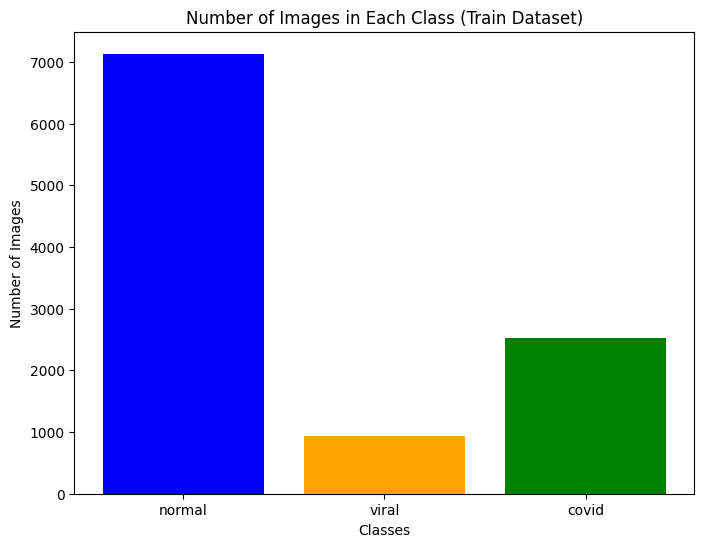

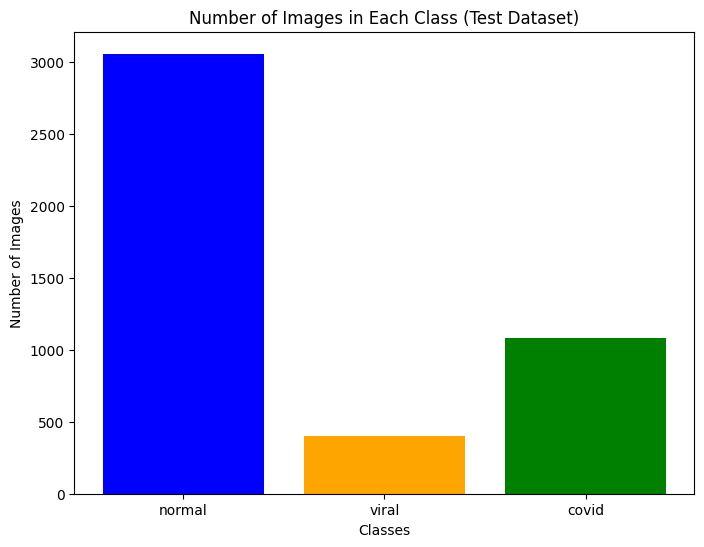

In [ ]:

import matplotlib.pyplot as plt

# Calculate the number of images for each class in the train dataset
train_num_images_per_class = [len(train_dataset.images[class_name]) for class_name in train_dataset.class_names]

# Plotting the bar chart for the train dataset
plt.figure(figsize=(8, 6))
plt.bar(train_dataset.class_names, train_num_images_per_class, color=['blue', 'orange', 'green'])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class (Train Dataset)')
plt.show()

# Calculate the number of images for each class in the test dataset
test_num_images_per_class = [len(test_dataset.images[class_name]) for class_name in test_dataset.class_names]

# Plotting the bar chart for the test dataset
plt.figure(figsize=(8, 6))
plt.bar(test_dataset.class_names, test_num_images_per_class, color=['blue', 'orange', 'green'])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class (Test Dataset)')
plt.show()


This code defines a function **show_images** that is intended to visualize a set of images along with their ground truth labels and predicted labels.

In [ ]:

class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

**dl_train** DataLoader display the first batch of training images.

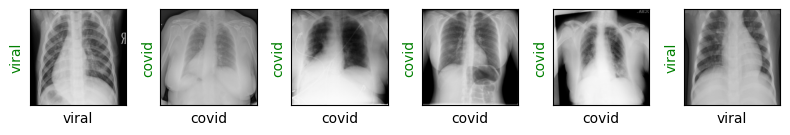

In [ ]:

images, labels = next(iter(dl_train))
show_images(images, labels, labels)

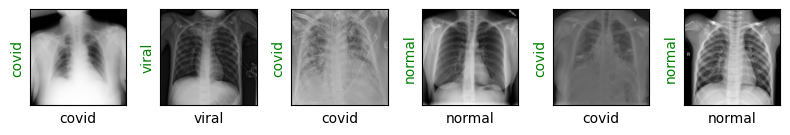

In [ ]:

images, labels = next(iter(dl_test))
show_images(images, labels, labels)

###7. Creating a Model

This code uses PyTorch's torchvision library to load the **ResNet 18**

**ResNet-18** :  popular deep learning architecture known for its effectiveness in image classification tasks.

This architecture includes convolutional layers, batch normalization, activation functions, and fully connected layers

The use of **pretrained=True** means that the model has already been trained on a large dataset (ImageNet), and you can use it as a feature extractor or fine-tune it for your specific task.



In [ ]:

resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This code prepares the ResNet-18 model for training on your three-class classification task.

This code modifies the last fully connected layer of a pretrained ResNet-18 model to adapt it for a specific 3 class classification task.

**in_features** parameter is set to 512, which is the number of output features from the preceding layers in ResNet-18.

**out_features** parameter is set to 3, reflecting the number of classes.

In [ ]:

resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Que : why do we check how well the model is working on data, before training the model on data. Can’t we do it after training the model?**


The primary reason for evaluating the model after training is to assess its performance on unseen data, validate its generalization capabilities, and make informed decisions about its effectiveness.

In [ ]:

def show_preds():
    resnet18.eval() # set to evaluation mode
    images, labels = next(iter(dl_test)) # Get a batch of test images and label
    outputs = resnet18(images)  # Forward pass to obtain model predictions
    _, preds = torch.max(outputs, 1)   # Extract predicted class indices
    show_images(images, labels, preds)

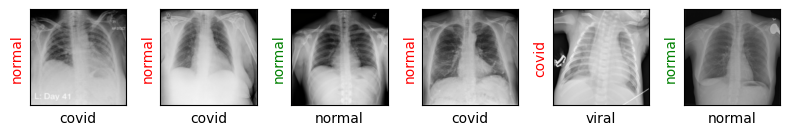

In [ ]:

show_preds()

###8. Training the Model

This code defines a training function (train) for the ResNet-18 model in the context of the COVID-19 detection project

The function orchestrates the training process of the ResNet-18 model for a specified number of epochs. It monitors the training loss, periodically evaluates the model on the validation set, and stops early if a performance condition is met.

**The show_preds()** function likely visualizes model predictions for monitoring during training.

Steps :   
1. Iterates over epochs to train the model.
2.  Sets the model to the training phase
3. Iterates over batches in the training data (dl_train)
4. Periodically (every 20 training steps), switches the model to evaluation mode (resnet18.eval()) and evaluates its performance on the test set (dl_test).
5. Calls the show_preds function to visualize predictions on test images.
6. Checks if the accuracy on the test set is greater than or equal to 95%.
- If the condition is satisfied, the training loop is stopped, indicating that the model has achieved satisfactory performance.
7.Computes and prints the average training loss for the epoch.

  


In [ ]:

def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.0666, Accuracy: 0.4382


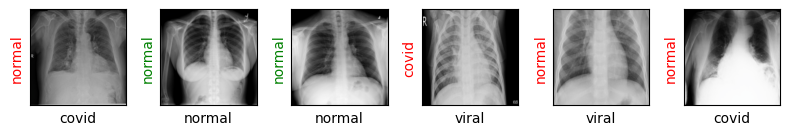

Evaluating at step 20
Validation Loss: 0.8191, Accuracy: 0.5854


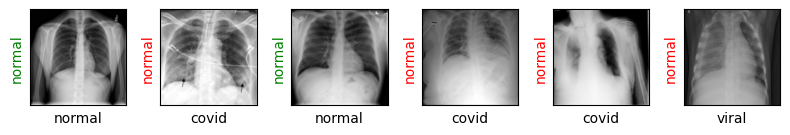

Evaluating at step 40
Validation Loss: 0.5369, Accuracy: 0.8094


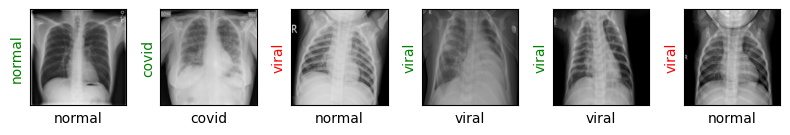

Evaluating at step 60
Validation Loss: 0.3890, Accuracy: 0.8662


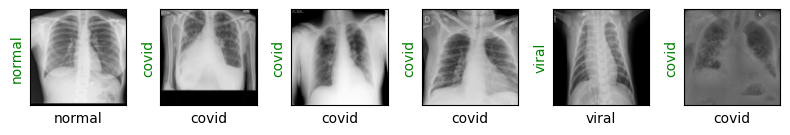

Evaluating at step 80
Validation Loss: 0.3059, Accuracy: 0.9014


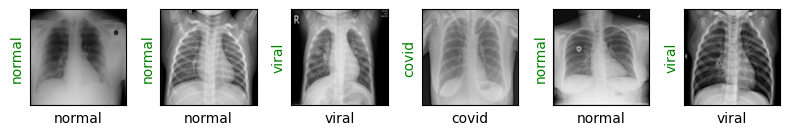

Evaluating at step 100
Validation Loss: 0.2778, Accuracy: 0.9038


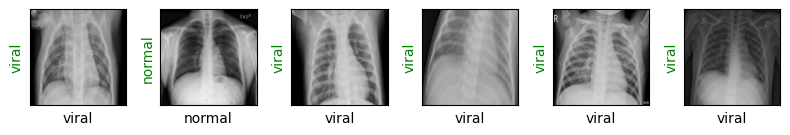

Evaluating at step 120
Validation Loss: 0.2766, Accuracy: 0.9082


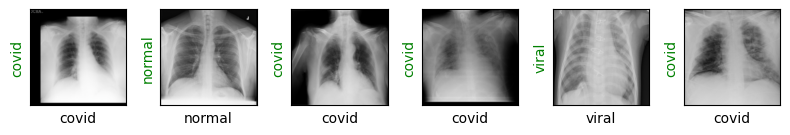

Evaluating at step 140
Validation Loss: 0.2537, Accuracy: 0.9122


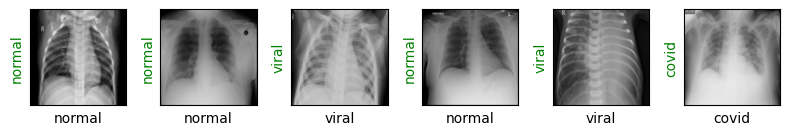

Evaluating at step 160
Validation Loss: 0.2164, Accuracy: 0.9276


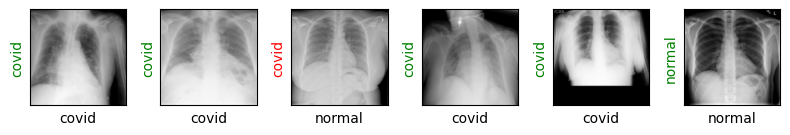

Evaluating at step 180
Validation Loss: 0.2135, Accuracy: 0.9228


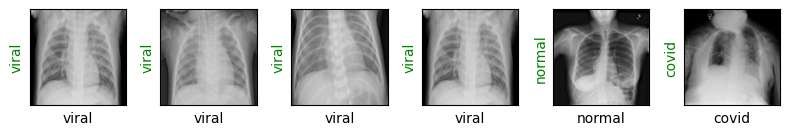

Evaluating at step 200
Validation Loss: 0.2003, Accuracy: 0.9296


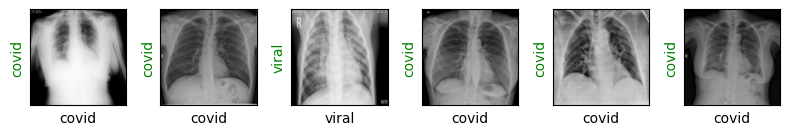

Evaluating at step 220
Validation Loss: 0.1675, Accuracy: 0.9507


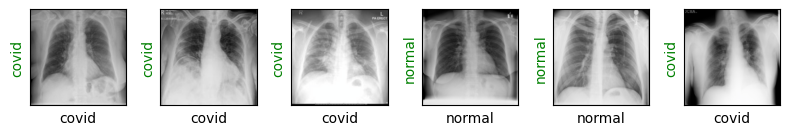

Performance condition satisfied, stopping..
CPU times: user 1h 32min 17s, sys: 40.7 s, total: 1h 32min 58s
Wall time: 1h 35min 16s


In [ ]:

%%time

train(epochs=1)

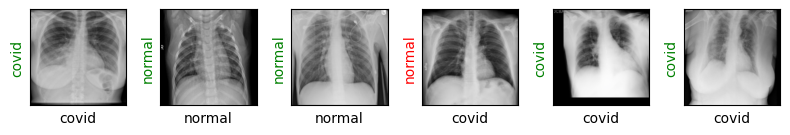

In [ ]:
show_preds()

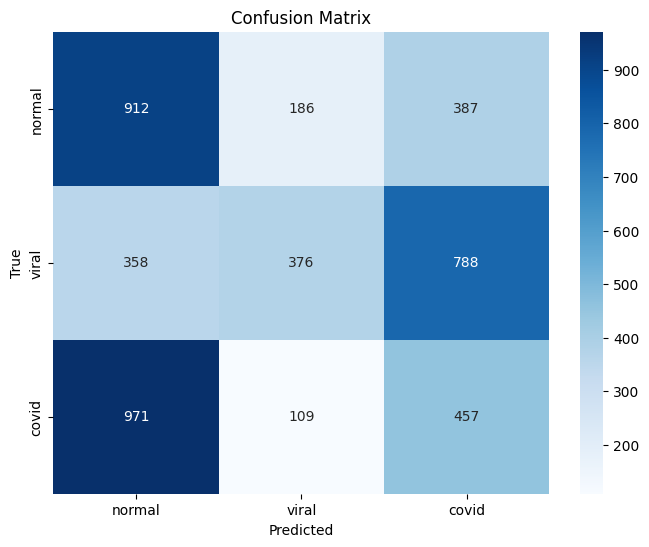

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model to evaluation mode
resnet18.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataset
for images, labels in dl_test:
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)

    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds.numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.class_names, yticklabels=train_dataset.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
